## SARIMA

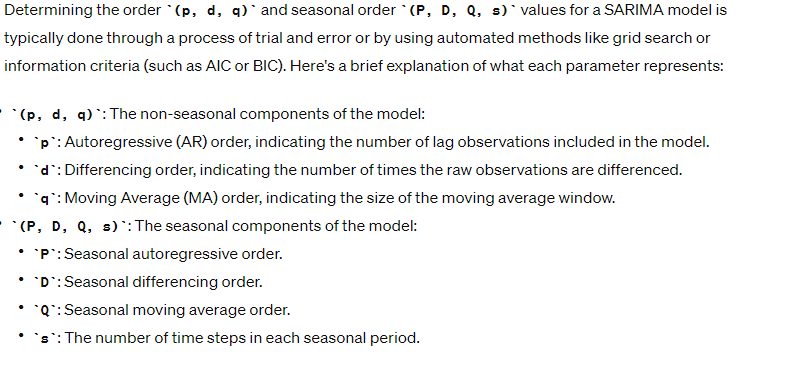

In [1]:
# !pip install arch
# !pip install scikit-optimize #  Bayesian optimization of SARIMA parameters
# !pip install scikit-optimize


In [2]:
from google.colab import files
uploaded = files.upload()


In [40]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from arch.unitroot import PhillipsPerron
import itertools
from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency


In [ ]:
# Read the CSV file into a DataFrame
data = pd.read_csv('/content/Monthly_arrival_data.csv')
# Assuming the 'Date' column is not already in datetime format
data['date'] = pd.to_datetime(data['date'],  format='%m/%d/%Y')

# Set 'Date' column as index
data.set_index('date', inplace=True)
data.index.freq = 'MS'  # if date start from first its MS, End 'M" and 'BM for mid'
# Define COVID period
# Define COVID period
covid_start = pd.to_datetime('2020-01-01')
covid_end = pd.to_datetime('2021-01-01')

# Create COVID effect column
data['COVID_Effect'] = (data.index >= covid_start) & (data.index < covid_end)
data['COVID_Effect'] = data['COVID_Effect'].astype(int)  # Convert boolean to integer

data.tail()

In [ ]:
# Define a function to perform stationarity tests
def stationarity_tests(timeseries):
    # ADF Test
    adf_result = adfuller(timeseries)
    print("ADF Test:")
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")

    adf_hypothesis = "Null Hypothesis (H0): The time series has a unit root (non-stationary).\nAlternative Hypothesis (H1): The time series does not have a unit root (stationary)."
    if adf_result[1] < 0.05:
        print("Reject Null Hypothesis - Time series is stationary")
    else:
        print("Fail to Reject Null Hypothesis - Time series is non-stationary")
    print("Hypothesis:")
    print(adf_hypothesis)
    # PP Test
    pp_result = PhillipsPerron(timeseries)
    print("\nPhillips-Perron Test:")
    print("PP Statistic:", pp_result.stat)
    print("p-value:", pp_result.pvalue)

    pp_hypothesis = "Null Hypothesis (H0): The time series has a unit root (non-stationary).\nAlternative Hypothesis (H1): The time series does not have a unit root (stationary)."
    if pp_result.pvalue < 0.05:
        print("Reject Null Hypothesis - Time series is stationary")
    else:
        print("Fail to Reject Null Hypothesis - Time series is non-stationary")
    print("Hypothesis:")
    print(pp_hypothesis)

    # KPSS Test
    kpss_result = kpss(timeseries)
    print("\nKPSS Test:")
    print("KPSS Statistic:", kpss_result[0])
    print("p-value:", kpss_result[1])
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value}")

    kpss_hypothesis = "Null Hypothesis (H0): The time series is stationary around a deterministic trend.\nAlternative Hypothesis (H1): The time series has a unit root (non-stationary)."
    if kpss_result[1] < 0.05:
        print("Reject Null Hypothesis - Time series is non-stationary")
    else:
        print("Fail to Reject Null Hypothesis - Time series is stationary")
    print("Hypothesis:")
    print(kpss_hypothesis)

# Call the function with your time series data
stationarity_tests(data['Arrivals'])
print('first difference of arrivals#######################')
stationarity_tests(data['Arrivals'].diff().dropna())
print('takig log of arrivalsffffffffffffffffffffffffffffff#######################')
stationarity_tests(np.log(data['Arrivals']))

# arrange data based on stationarity check

In [43]:
# log transformation perform better for stationary so log data will be used for further study
data['ArrivalsL']=np.log(data['Arrivals'])
data.head()

,Date,Arrivals,COVID_Effect,ArrivalsL
date,,,,
1992-01-01,Jan-92,17451,0,9.767152
1992-02-01,Feb-92,27489,0,10.221541
1992-03-01,Mar-92,31505,0,10.357902
1992-04-01,Apr-92,30682,0,10.331431
1992-05-01,May-92,29089,0,10.278115


In [52]:
# BayesSearch will be updated latter

In [54]:
# def sarima_model(order, seasonal_order):
#     model = SARIMAX(data['ArrivalsL'], order=order,exog=data['COVID_Effect'], seasonal_order=seasonal_order)
#     result = model.fit()
#     return result.aic


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt

# Define the range of parameters to search
p = d = q = range(0, 3)  # Orders for ARIMA components
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]  # Seasonal orders

# Load or define your time series data (replace this with your actual data)
# For example, assuming 'data' is your time series data
# Replace it with your actual time series data
# data = pd.read_csv('your_data.csv', parse_dates=['Date'], index_col='Date')

# Define a function to perform grid search
def grid_search_sarima(data, seasonal_orders):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    for order in list(itertools.product(p, d, q)):
        for seasonal_order in seasonal_orders:
            try:
                model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
            except:
                continue

    return best_order, best_seasonal_order, best_aic

# Perform grid search
best_order, best_seasonal_order, best_aic = grid_search_sarima(data['ArrivalsL'], seasonal_pdq)

# Print the best SARIMA parameters
print("Best SARIMA Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
print("Best AIC:", best_aic)


In [7]:
# Split the data into train and test sets
train_size = int(len(data['ArrivalsL']) * 0.8)
train, test = data['ArrivalsL'][:train_size], data['ArrivalsL'][train_size:]
# Split the data into train and test sets covid effect
train_size = int(len(data['COVID_Effect']) * 0.8)
COVIDtrain, COVIDtest = data['COVID_Effect'][:train_size], data['COVID_Effect'][train_size:]

Mean Squared Error: 4.30948577318325


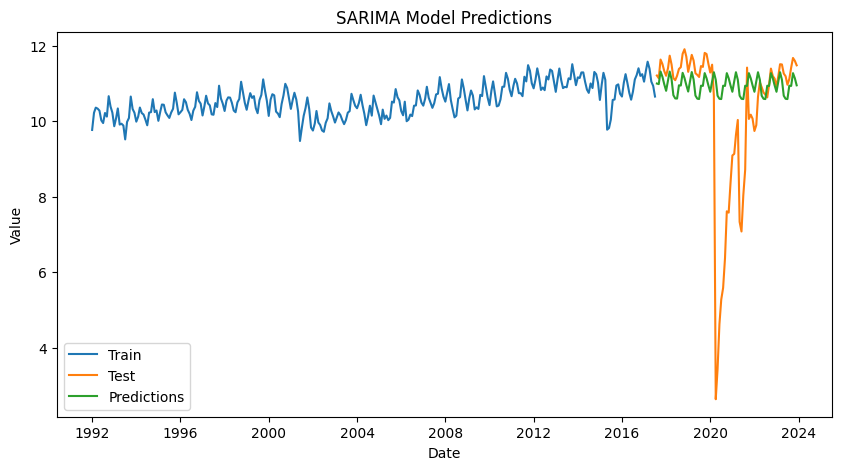

In [88]:
# Fit SARIMA model to training data
order= (1, 0, 0)
seasonal_order=(1, 1, 2, 12)
# Best AIC: 557.2075394420219

model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, exog=COVIDtrain, enforce_invertibility=False)
result = model.fit()

# Make predictions
predictions = result.predict(start=test.index[0], end=test.index[-1],exog=COVIDtest)

# Calculate MSE
mse = mean_squared_error(test, predictions)
print('Mean Squared Error:', mse)

# Visualize predictions
plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.title('SARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()



In [8]:
# 1. Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100
    # 2. Calculate MSE
def calculate_mse(actual, predicted):
    return np.mean((actual - predicted)**2)

In [44]:
# Fit SARIMA model to training data
order= (1, 0, 0)
seasonal_order=(1, 1, 2, 12)
# Best AIC: 557.2075394420219
model = SARIMAX(data['ArrivalsL'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, exog=data['COVID_Effect'], enforce_invertibility=False)
sarima_results = model.fit()
# Print model summary
print(sarima_results.summary())
# Get model summary as DataFrame
summary_df = sarima_results.summary().tables[2]
summary_df = pd.DataFrame(summary_df.data)

# Save summary to CSV file
summary_df.to_csv('sarima_summary.csv', index=False)

                                        SARIMAX Results                                        
Dep. Variable:                               ArrivalsL   No. Observations:                  384
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -261.466
Date:                                 Fri, 29 Mar 2024   AIC                            534.932
Time:                                         05:23:19   BIC                            558.028
Sample:                                     01-01-1992   HQIC                           544.128
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
COVID_Effect    -1.0222      0.214     -4.766      0.000      -1.442  

In [10]:
# Make predictions
predictions = sarima_results.predict(start=data.index[0], end=data.index[-1],exog=data['COVID_Effect'])
# actual_values=np.exp(data['ArrivalsL'])
# predicted_values=np.exp(predictions)
actual_values=data['ArrivalsL']
predicted_values=predictions

# Calculate MSE
mse = mean_squared_error(actual_values, predicted_values )
print('Mean Squared Error:', mse)
mape = calculate_mape(actual_values, predicted_values)
print('Mean Absolute Percentage Error (MAPE):', mape)
mse = calculate_mse(actual_values, predicted_values)
print('Mean Squared Error (MSE):', mse)
# Perform Chi-squared test
# Ensure observed and expected frequencies have the same sum
# Calculate the Chi-squared statistic and p-value for the observed and expected values
chi2_stat, p_value, _, _ = chi2_contingency(np.array([actual_values, predicted_values]))
print('Chi-squared (χ²) statistic:', chi2_stat)
print('p-value:', p_value)



# # Visualize predictions
# plt.figure(figsize=(10, 5))
# plt.plot(train, label='Train')
# plt.plot(test, label='Test')
# plt.plot(predictions, label='Predictions')
# plt.title('SARIMA Model Predictions')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

Mean Squared Error: 0.8867882394737894
Mean Absolute Percentage Error (MAPE): 3.6764609875466507
Mean Squared Error (MSE): 0.8867882394737894
Chi-squared (χ²) statistic: 24.40230313807844
p-value: 1.0


In [ ]:

# # Fit SARIMA model with best parameters to the data
# best_model = SARIMAX(data['ArrivalsL'], order=best_order, seasonal_order=best_seasonal_order)
# best_results = best_model.fit()

# # Plot actual data and forecasted values
# plt.figure(figsize=(12, 6))
# plt.plot(data.index, data['ArrivalsL'], label='Actual')
# forecast = best_results.get_forecast(steps=len(data))
# plt.plot(data.index, forecast.predicted_mean, color='red', label='Forecast')
# plt.fill_between(data.index, forecast.conf_int()['lower ArrivalsL'], forecast.conf_int()['upper ArrivalsL'], color='pink', alpha=0.5)
# plt.xlabel('Date')
# plt.ylabel('Arrivals')
# plt.title('SARIMA Forecast')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# predictions= result.predict(start=data.index[0], end=data.index[-1],exog=data['COVID_Effect'])
def Stat_check(result,data,predictions):
  # actual_values=np.exp(data['ArrivalsL'])
  # predicted_values=np.exp(predictions)
  actual_values=data['ArrivalsL']
  predicted_values=predictions

  # Calculate MSE
  mse = mean_squared_error(actual_values, predicted_values )
  print('Mean Squared Error:', mse)
  mape = calculate_mape(actual_values, predicted_values)
  print('Mean Absolute Percentage Error (MAPE):', mape)
  mse = calculate_mse(actual_values, predicted_values)
  print('Mean Squared Error (MSE):', mse)
  # Perform Chi-squared test
  # Ensure observed and expected frequencies have the same sum
  # Calculate the Chi-squared statistic and p-value for the observed and expected values
  chi2_stat, p_value, _, _ = chi2_contingency(np.array([actual_values, predicted_values]))
  print('Chi-squared (χ²) statistic:', chi2_stat)
  print('p-value:', p_value)
Stat_check(sarima_results,data,predictions)

In [98]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Combine the time series data with the exogenous variable
combined_data = pd.concat([data['ArrivalsL'], data['COVID_Effect']], axis=1)

# Fit the Exponential Smoothing model
model = ExponentialSmoothing(combined_data.iloc[:, 0], seasonal_periods=12, trend='add', seasonal='add')

# Fit the model
hw_add_results = model.fit()

# Get the parameters of the model
params = hw_add_results.params

# Assess the significance of the COVID_Effect variable
# You can use statistical tests or confidence intervals here

# Make predictions
predictions = hw_add_results.predict(start=data.index[0], end=data.index[-1])
print(hw_add_results.summary())
summary_df = params
summary_df = pd.DataFrame(summary_df)
# Save summary to CSV file
summary_df.to_csv('hw_add_results_summary.csv', index=True)
# Visualize the predictions
# You can plot the original time series, the COVID_Effect variable, and the predictions to examine the effect
# You can also compare the predictions with and without the COVID_Effect variable to assess its impact


                       ExponentialSmoothing Model Results                       
Dep. Variable:                ArrivalsL   No. Observations:                  384
Model:             ExponentialSmoothing   SSE                             92.464
Optimized:                         True   AIC                           -514.750
Trend:                         Additive   BIC                           -451.540
Seasonal:                      Additive   AICC                          -512.876
Seasonal Periods:                    12   Date:                 Fri, 29 Mar 2024
Box-Cox:                          False   Time:                         07:17:32
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9633490                alpha                 True
smoothing_trend          

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Combine the time series data with the exogenous variable
combined_data = pd.concat([data['ArrivalsL'], data['COVID_Effect']], axis=1)

# Fit the Exponential Smoothing model
model = ExponentialSmoothing(combined_data.iloc[:, 0], seasonal_periods=12, trend='add', seasonal='mul')

# Fit the model
hw_mul_results = model.fit()

# Get the parameters of the model
params = hw_mul_results.params

# Assess the significance of the COVID_Effect variable
# You can use statistical tests or confidence intervals here

# Make predictions
predictions = hw_mul_results.predict(start=data.index[0], end=data.index[-1])
print(hw_mul_results.summary())
summary_df = params
summary_df = pd.DataFrame(summary_df)
# Save summary to CSV file
summary_df.to_csv('hw_mul_results_summary.csv', index=True)
# Visualize the predictions
# You can plot the original time series, the COVID_Effect variable, and the predictions to examine the effect
# You can also compare the predictions with and without the COVID_Effect variable to assess its impact

In [108]:
pd.DataFrame(hw_mul_result.summary().tables[1]).to_csv('hw_add_results_summary.csv', index=True,header=False)
pd.DataFrame(hw_add_result.summary().tables[1]).to_csv('hw_mul_results_summary.csv', index=True,header=False)

In [14]:
# Step 5: Holt-Winter Exponential Smoothing

hw_mul_model = ExponentialSmoothing(combined_data['ArrivalsL'], seasonal_periods=12, trend='add', seasonal='mul')
hw_mul_results = hw_mul_model.fit()

# Make predictions
predictions = hw_mul_results.predict(start=data.index[0], end=data.index[-1])
print('statistical test of multiplicative model')
Stat_check(hw_mul_results,data,predictions)



statistical test of multiplicative model
Mean Squared Error: 0.2414186189860289
Mean Absolute Percentage Error (MAPE): 2.400065586094126
Mean Squared Error (MSE): 0.2414186189860289
Chi-squared (χ²) statistic: 6.518341241506075
p-value: 1.0


In [76]:
# Create a DataFrame with zeros for the post-COVID effect period
# post_covid_dates = pd.date_range(start=data.index[-1], end=data.index[-1] + pd.DateOffset(years=5), freq='M')
# post_covid_effect = np.zeros(len(post_covid_dates))
# post_covid_effect
data.index[-1] + pd.DateOffset(years=7)

Timestamp('2030-12-01 00:00:00')

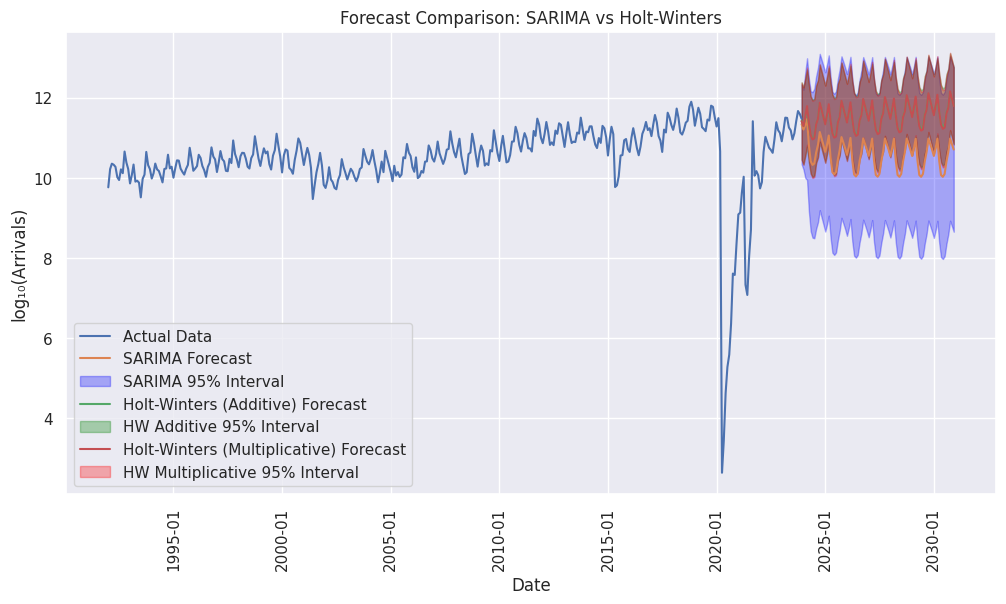

In [94]:
import seaborn as sns
from matplotlib.dates import DateFormatter, MonthLocator
sns.set()
Forecast_yr=7
# # Create a DataFrame with zeros for the post-COVID effect period
# post_covid_dates = pd.date_range(start=data.index[-1], end=data.index[-1] + pd.DateOffset(years=Forecast_yr), freq='M')
# post_covid_effect = np.zeros(len(post_covid_dates))
# sarima_model = SARIMAX(data['ArrivalsL'],exog=data['COVID_Effect'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False,  enforce_invertibility=False)
# sarima_result = sarima_model.fit()
# sarima_predictions = sarima_result.get_prediction(start=data.index[-1], end=data.index[-1] + pd.DateOffset(years=5),exog=post_covid_effect, dynamic=False)
# sarima_pred_mean = sarima_predictions.predicted_mean
# sarima_conf_int = sarima_predictions.conf_int(alpha=0.05)
# Create a DataFrame with zeros for the post-COVID effect period
sarima_model = SARIMAX(data['ArrivalsL'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False,  enforce_invertibility=False)
sarima_result = sarima_model.fit()
sarima_predictions = sarima_result.get_prediction(start=data.index[-1], end=data.index[-1] + pd.DateOffset(years=Forecast_yr), dynamic=False)
sarima_pred_mean = sarima_predictions.predicted_mean
sarima_conf_int = sarima_predictions.conf_int(alpha=0.05)

# Holt-Winters (Additive) forecast
hw_add_model = ExponentialSmoothing(data['ArrivalsL'], seasonal_periods=12, trend='add', seasonal='add')
hw_add_result = hw_add_model.fit()
hw_add_predictions = hw_add_result.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(years=Forecast_yr))

# Calculate residuals for Holt-Winters (Additive)
hw_add_residuals = data['ArrivalsL'] - hw_add_result.fittedvalues

# Calculate 95% confidence interval for Holt-Winters (Additive)
hw_add_conf_int = pd.concat([hw_add_predictions - 1.96 * hw_add_residuals.std(),
                             hw_add_predictions + 1.96 * hw_add_residuals.std()], axis=1)

# Holt-Winters (Multiplicative) forecast
hw_mul_model = ExponentialSmoothing(data['ArrivalsL'], seasonal_periods=12, trend='add', seasonal='mul')
hw_mul_result = hw_mul_model.fit()
hw_mul_predictions = hw_mul_result.predict(start=data.index[-1], end=data.index[-1] + pd.DateOffset(years=Forecast_yr))

# Calculate residuals for Holt-Winters (Multiplicative)
hw_mul_residuals = data['ArrivalsL'] - hw_mul_result.fittedvalues

# Calculate 95% confidence interval for Holt-Winters (Multiplicative)
hw_mul_conf_int = pd.concat([hw_mul_predictions - 1.96 * hw_mul_residuals.std(),
                             hw_mul_predictions + 1.96 * hw_mul_residuals.std()], axis=1)

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['ArrivalsL'], label='Actual Data')
plt.plot(sarima_pred_mean.index, sarima_pred_mean, label='SARIMA Forecast')
plt.fill_between(sarima_pred_mean.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='blue', alpha=0.3, label='SARIMA 95% Interval')
plt.plot(hw_add_predictions.index, hw_add_predictions, label='Holt-Winters (Additive) Forecast')
plt.fill_between(hw_add_predictions.index, hw_add_conf_int.iloc[:, 0], hw_add_conf_int.iloc[:, 1], color='green', alpha=0.3, label='HW Additive 95% Interval')
plt.plot(hw_mul_predictions.index, hw_mul_predictions, label='Holt-Winters (Multiplicative) Forecast')
plt.fill_between(hw_mul_predictions.index, hw_mul_conf_int.iloc[:, 0], hw_mul_conf_int.iloc[:, 1], color='red', alpha=0.3, label='HW Multiplicative 95% Interval')
plt.title('Forecast Comparison: SARIMA vs Holt-Winters')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
# Set frequency of date ticks to display every month
# plt.gca().xaxis.set_major_locator(MonthLocator(1)) #display at 5-month intervals
plt.xlabel('Date')  # Rotate x-axis labels by 90 degrees
plt.ylabel('log\u2081\u2080(Arrivals)')  # Mathematical expression for log base 10
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create a DataFrame for the forecasted data
forecast_data = pd.DataFrame({
    'Date': sarima_pred_mean.index,
    'SARIMA_Forecast': np.exp(sarima_pred_mean),
    'HW_Additive_Forecast': np.exp(hw_add_predictions),
    'HW_Multiplicative_Forecast': np.exp(hw_mul_predictions)
})

# Set the 'Date' column as the index
forecast_data.set_index('Date', inplace=True)

# Save the forecasted data to a CSV file
forecast_data.to_csv('forecasted_data.csv')

# Display the DataFrame
print(forecast_data)


In [96]:
# Resample the forecasted data by year and calculate the sum
sum_by_year = forecast_data.resample('Y').sum()

# Export the sum by year to a CSV file
sum_by_year.to_csv('sum_forecast_by_year.csv')

# Display the sum by year DataFrame
print(sum_by_year)


            SARIMA_Forecast  HW_Additive_Forecast  HW_Multiplicative_Forecast
Date                                                                         
2023-12-31     84245.239264          9.173702e+04                9.095454e+04
2024-12-31    668447.498205          1.122408e+06                1.130875e+06
2025-12-31    509062.850706          1.177237e+06                1.184174e+06
2026-12-31    484415.081843          1.234745e+06                1.239987e+06
2027-12-31    480282.440875          1.295062e+06                1.298431e+06
2028-12-31    479401.704605          1.358325e+06                1.359632e+06
2029-12-31    479282.240667          1.424679e+06                1.423719e+06
2030-12-31    479243.417921          1.494274e+06                1.490829e+06


In [90]:
data['Arrivals'].tail()

date
2023-08-01     67153
2023-09-01     91012
2023-10-01    117306
2023-11-01    108630
2023-12-01     96568
Freq: MS, Name: Arrivals, dtype: int64

In [ ]:
import pandas as pd

# Create a DataFrame for the forecasted data with upper and lower limits
forecast_data = pd.DataFrame({
    'Date': sarima_pred_mean.index,
    'SARIMA_Forecast': np.exp(sarima_pred_mean),
    'SARIMA_Upper_Limit': np.exp(sarima_conf_int.iloc[:, 1]),
    'SARIMA_Lower_Limit': np.exp(sarima_conf_int.iloc[:, 0]),
    'HW_Additive_Forecast': np.exp(hw_add_predictions),
    'HW_Additive_Upper_Limit': hw_add_conf_int.iloc[:, 1].values,
    'HW_Additive_Lower_Limit': hw_add_conf_int.iloc[:, 0].values,
    'HW_Multiplicative_Forecast': np.exp(hw_mul_predictions),
    'HW_Multiplicative_Upper_Limit': hw_mul_conf_int.iloc[:, 1].values,
    'HW_Multiplicative_Lower_Limit': hw_mul_conf_int.iloc[:, 0].values
})

# Set the 'Date' column as the index
forecast_data.set_index('Date', inplace=True)

# Save the forecasted data to a CSV file
forecast_data.to_csv('forecasted_data_with_limits.csv')

# Display the DataFrame
print(forecast_data)


In [93]:
# Resample the forecasted data by year and calculate the sum
sum_by_year = forecast_data.resample('Y').sum()

# Resample the upper and lower limit dataframes by year and calculate the sum
upper_limit_by_year = forecast_data['SARIMA_Upper_Limit'].resample('Y').sum()
lower_limit_by_year = forecast_data['SARIMA_Lower_Limit'].resample('Y').sum()

# Combine the sum_by_year with upper and lower limits
sum_by_year['SARIMA_Upper_Limit'] = upper_limit_by_year
sum_by_year['SARIMA_Lower_Limit'] = lower_limit_by_year

# Export the sum by year with upper and lower limits to a CSV file
sum_by_year.to_csv('sum_forecast_by_year_with_limits.csv')

# Display the sum by year DataFrame
print(sum_by_year)


            SARIMA_Forecast  SARIMA_Upper_Limit  SARIMA_Lower_Limit  \
Date                                                                  
2023-12-31     84245.239264        2.280502e+05        31121.477545   
2024-12-31    668447.498205        3.693050e+06       134126.855914   
2025-12-31    509062.850706        3.794935e+06        68292.862897   
2026-12-31    484415.081843        3.680537e+06        63757.079838   
2027-12-31    480282.440875        3.675660e+06        62756.510755   
2028-12-31    479401.704605        3.689952e+06        62284.384123   
2029-12-31    479282.240667        3.708991e+06        61933.782050   
2030-12-31    479243.417921        3.728615e+06        61597.841633   

            HW_Additive_Forecast  HW_Additive_Upper_Limit  \
Date                                                        
2023-12-31          9.173702e+04                12.389716   
2024-12-31          1.122408e+06               148.474110   
2025-12-31          1.177237e+06             

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


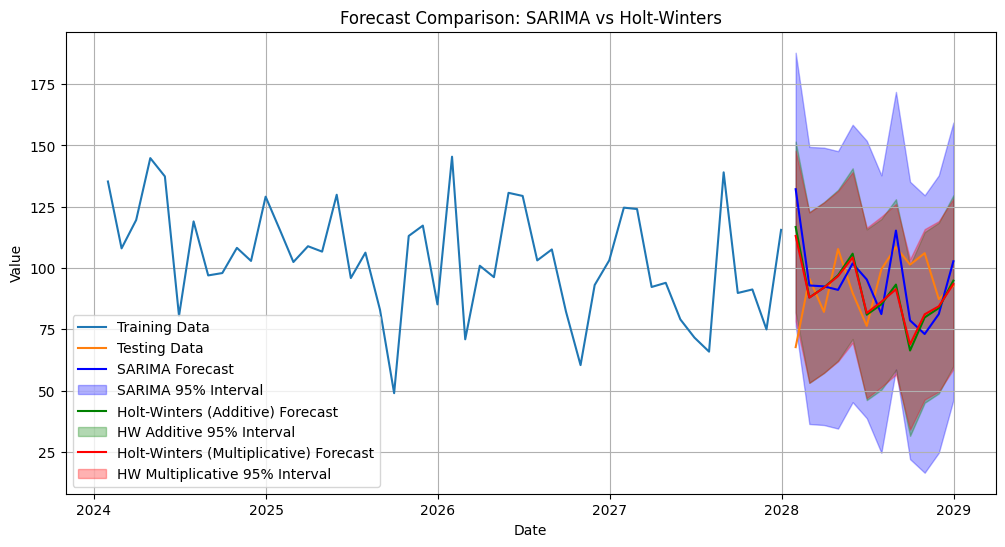

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Step 1: Generate monthly data for 5 years
np.random.seed(0)  # for reproducibility
dates = pd.date_range(start='2024-01-01', periods=60, freq='M')
monthly_data = pd.Series(np.random.normal(100, 20, size=len(dates)), index=dates)

# Step 2: Split data into training and testing sets
train = monthly_data.iloc[:48]  # 4 years of data for training
test = monthly_data.iloc[48:]   # 1 year of data for testing

# Step 3: SARIMA forecast
order = (1, 1, 1)  # example order for SARIMA model
seasonal_order = (1, 1, 1, 12)  # example seasonal order for SARIMA model

sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()
sarima_predictions = sarima_result.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
sarima_pred_mean = sarima_predictions.predicted_mean
sarima_conf_int = sarima_predictions.conf_int(alpha=0.05)

# Step 4: Holt-Winters (Additive) forecast
hw_add_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
hw_add_result = hw_add_model.fit()
hw_add_predictions = hw_add_result.predict(start=test.index[0], end=test.index[-1])

# Calculate residuals for Holt-Winters (Additive)
hw_add_residuals = train - hw_add_result.fittedvalues

# Calculate 95% confidence interval for Holt-Winters (Additive)
hw_add_conf_int = pd.concat([hw_add_predictions - 1.96 * hw_add_residuals.std(),
                             hw_add_predictions + 1.96 * hw_add_residuals.std()], axis=1)

# Step 5: Holt-Winters (Multiplicative) forecast
hw_mul_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul')
hw_mul_result = hw_mul_model.fit()
hw_mul_predictions = hw_mul_result.predict(start=test.index[0], end=test.index[-1])

# Calculate residuals for Holt-Winters (Multiplicative)
hw_mul_residuals = train - hw_mul_result.fittedvalues

# Calculate 95% confidence interval for Holt-Winters (Multiplicative)
hw_mul_conf_int = pd.concat([hw_mul_predictions - 1.96 * hw_mul_residuals.std(),
                             hw_mul_predictions + 1.96 * hw_mul_residuals.std()], axis=1)

# Step 6: Visualize the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(sarima_pred_mean.index, sarima_pred_mean, label='SARIMA Forecast', color='blue')
plt.fill_between(sarima_pred_mean.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='blue', alpha=0.3, label='SARIMA 95% Interval')
plt.plot(hw_add_predictions.index, hw_add_predictions, label='Holt-Winters (Additive) Forecast', color='green')
plt.fill_between(hw_add_predictions.index, hw_add_conf_int.iloc[:, 0], hw_add_conf_int.iloc[:, 1], color='green', alpha=0.3, label='HW Additive 95% Interval')
plt.plot(hw_mul_predictions.index, hw_mul_predictions, label='Holt-Winters (Multiplicative) Forecast', color='red')
plt.fill_between(hw_mul_predictions.index, hw_mul_conf_int.iloc[:, 0], hw_mul_conf_int.iloc[:, 1], color='red', alpha=0.3, label='HW Multiplicative 95% Interval')
plt.title('Forecast Comparison: SARIMA vs Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


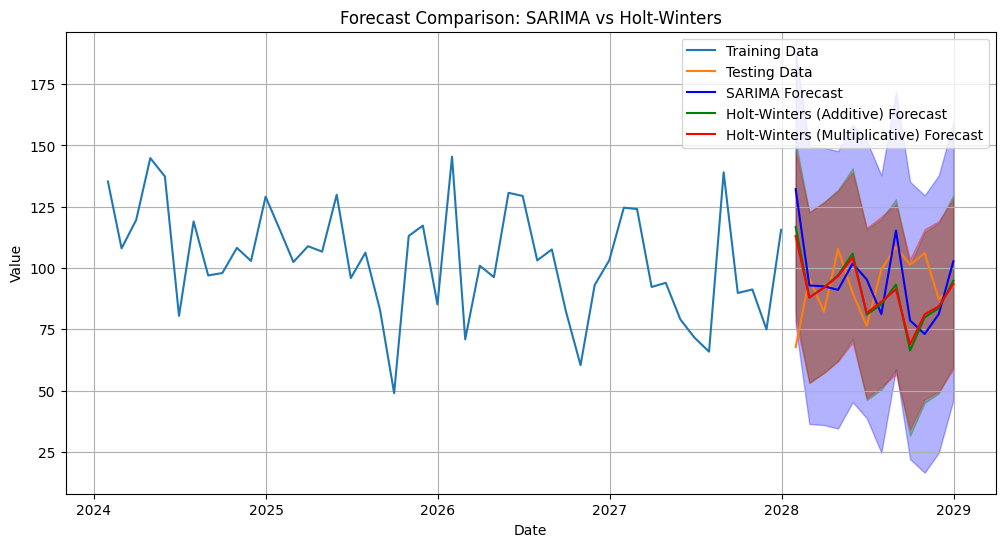

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Step 1: Generate monthly data for 5 years
np.random.seed(0)  # for reproducibility
dates = pd.date_range(start='2024-01-01', periods=60, freq='M')
monthly_data = pd.Series(np.random.normal(100, 20, size=len(dates)), index=dates)

# Step 2: Split data into training and testing sets
train = monthly_data.iloc[:48]  # 4 years of data for training
test = monthly_data.iloc[48:]   # 1 year of data for testing

# Step 3: SARIMA forecast
order = (1, 1, 1)  # example order for SARIMA model
seasonal_order = (1, 1, 1, 12)  # example seasonal order for SARIMA model

sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()
sarima_predictions = sarima_result.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
sarima_pred_mean = sarima_predictions.predicted_mean
sarima_conf_int = sarima_predictions.conf_int(alpha=0.05)

# Step 4: Holt-Winters (Additive) forecast
hw_add_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
hw_add_result = hw_add_model.fit()
hw_add_predictions = hw_add_result.predict(start=test.index[0], end=test.index[-1])

# Calculate residuals for Holt-Winters (Additive)
hw_add_residuals = train - hw_add_result.fittedvalues

# Calculate 95% confidence interval for Holt-Winters (Additive)
hw_add_conf_int = pd.concat([hw_add_predictions - 1.96 * hw_add_residuals.std(),
                             hw_add_predictions + 1.96 * hw_add_residuals.std()], axis=1)

# Step 5: Holt-Winters (Multiplicative) forecast
hw_mul_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul')
hw_mul_result = hw_mul_model.fit()
hw_mul_predictions = hw_mul_result.predict(start=test.index[0], end=test.index[-1])

# Calculate residuals for Holt-Winters (Multiplicative)
hw_mul_residuals = train - hw_mul_result.fittedvalues

# Calculate 95% confidence interval for Holt-Winters (Multiplicative)
hw_mul_conf_int = pd.concat([hw_mul_predictions - 1.96 * hw_mul_residuals.std(),
                             hw_mul_predictions + 1.96 * hw_mul_residuals.std()], axis=1)

# Step 6: Visualize the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(sarima_pred_mean.index, sarima_pred_mean, label='SARIMA Forecast', color='blue')
plt.fill_between(sarima_pred_mean.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='blue', alpha=0.3)
plt.plot(hw_add_predictions.index, hw_add_predictions, label='Holt-Winters (Additive) Forecast', color='green')
plt.fill_between(hw_add_predictions.index, hw_add_conf_int.iloc[:, 0], hw_add_conf_int.iloc[:, 1], color='green', alpha=0.3)
plt.plot(hw_mul_predictions.index, hw_mul_predictions, label='Holt-Winters (Multiplicative) Forecast', color='red')
plt.fill_between(hw_mul_predictions.index, hw_mul_conf_int.iloc[:, 0], hw_mul_conf_int.iloc[:, 1], color='red', alpha=0.3)
plt.title('Forecast Comparison: SARIMA vs Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


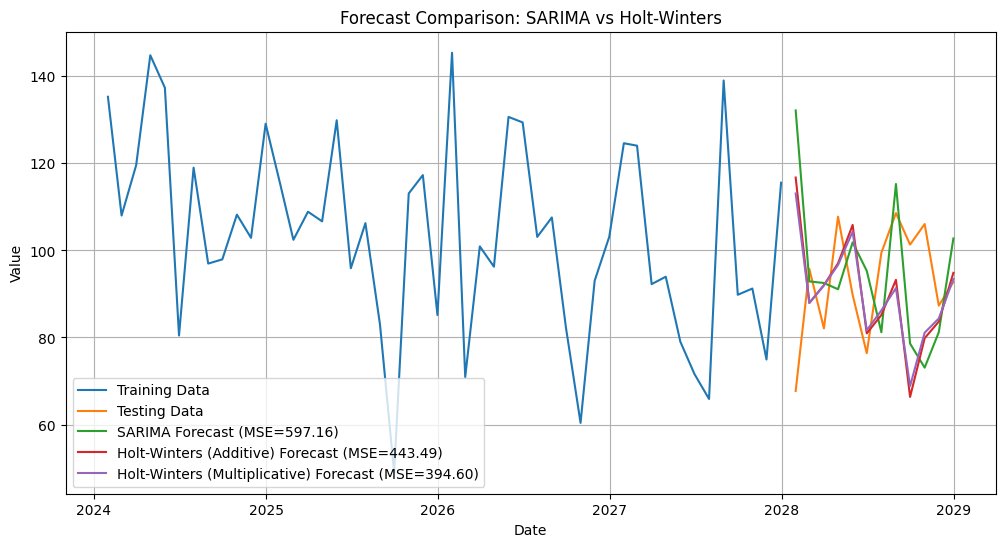

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Step 1: Generate monthly data for 5 years
np.random.seed(0)  # for reproducibility

dates = pd.date_range(start='2024-01-01', periods=60, freq='M')
monthly_data = pd.Series(np.random.normal(100, 20, size=len(dates)), index=dates)

# Step 2: Split data into training and testing sets
train = monthly_data.iloc[:48]  # 4 years of data for training
test = monthly_data.iloc[48:]   # 1 year of data for testing

# Step 3: SARIMA forecast
order = (1, 1, 1)  # example order for SARIMA model
seasonal_order = (1, 1, 1, 12)  # example seasonal order for SARIMA model

sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()
sarima_predictions = sarima_result.predict(start=test.index[0], end=test.index[-1])

# Step 4: Holt-Winters (Additive) forecast
hw_add_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
hw_add_result = hw_add_model.fit()
hw_add_predictions = hw_add_result.predict(start=test.index[0], end=test.index[-1])

# Step 5: Holt-Winters (Multiplicative) forecast
hw_mul_model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul')
hw_mul_result = hw_mul_model.fit()
hw_mul_predictions = hw_mul_result.predict(start=test.index[0], end=test.index[-1])

# Calculate MSE for each model
mse_sarima = mean_squared_error(test, sarima_predictions)
mse_hw_add = mean_squared_error(test, hw_add_predictions)
mse_hw_mul = mean_squared_error(test, hw_mul_predictions)

# Visualize the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(sarima_predictions.index, sarima_predictions, label=f'SARIMA Forecast (MSE={mse_sarima:.2f})')
plt.plot(hw_add_predictions.index, hw_add_predictions, label=f'Holt-Winters (Additive) Forecast (MSE={mse_hw_add:.2f})')
plt.plot(hw_mul_predictions.index, hw_mul_predictions, label=f'Holt-Winters (Multiplicative) Forecast (MSE={mse_hw_mul:.2f})')
plt.title('Forecast Comparison: SARIMA vs Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Step 6: Forecasting
# Step 6: Forecasting
# Forecast the next 3 years with 95% confidence interval
sarima_forecast = sarima_results.get_forecast(steps=36)
sarima_index = sarima_forecast.index  # Accessing the index of the forecasted values
sarima_mean = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int(alpha=0.05)  # 95% confidence interval

hw_add_forecast = hw_add_results.forecast(steps=36)
hw_add_index = hw_add_forecast.index  # Accessing the index of the forecasted values

hw_mul_forecast = hw_mul_results.forecast(steps=36)
hw_mul_index = hw_mul_forecast.index  # Accessing the index of the forecasted values

# Plotting
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(data['Date'], data['Values'], label='Actual')

# SARIMA forecast
plt.plot(sarima_index, sarima_mean, label='SARIMA Forecast', color='blue')
plt.fill_between(sarima_conf_int.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='blue', alpha=0.2)

# Holt-Winters Additive forecast
plt.plot(hw_add_index, hw_add_forecast, label='HW Additive Forecast', linestyle='--', color='orange')

# Holt-Winters Multiplicative forecast
plt.plot(hw_mul_index, hw_mul_forecast, label='HW Multiplicative Forecast', linestyle='--', color='green')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Forecast with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Forecast future values
forecast = result.get_forecast(steps=12, exog=pd.Series([True]*12, index=pd.date_range(start='2024-07-01', periods=12, freq='M')))  # Adjust steps as needed

## Plot the data and forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Arrivals'], label='Actual')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast.predicted_mean.index, forecast.conf_int()['lower Arrivals'], forecast.conf_int()['upper Arrivals'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Arrivals')
plt.title('SARIMA Forecast Including COVID-19 Effect')
plt.legend()
plt.show()

In [156]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Step 1: Generate Time Series Data with Year and Month
date_range = pd.date_range(start='2010-01-01', end='2023-12-01', freq='MS')
data = pd.DataFrame({'Date': date_range})
data['Values'] = np.random.randint(100, 1000, size=len(data))

# Step 2: Conduct Stationarity Tests
def stationarity_tests(timeseries):
    # ADF Test
    adf_result = adfuller(timeseries)
    print("ADF Test:")
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")

    # KPSS Test
    kpss_result = kpss(timeseries)
    print("\nKPSS Test:")
    print("KPSS Statistic:", kpss_result[0])
    print("p-value:", kpss_result[1])
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value}")

# Perform stationarity tests
stationarity_tests(data['Values'])

# Step 3: Prepare Suitable Data with COVID Effect (Simulated)
covid_start_date = pd.to_datetime('2020-01-01')
covid_end_date = pd.to_datetime('2021-01-01')
data.loc[(data['Date'] >= covid_start_date) & (data['Date'] < covid_end_date), 'Values'] *= 0.8

# Step 4: Analyze ARIMA and Seasonal Orders and Execute SARIMA
# Example: Determine suitable ARIMA and SARIMA orders
arima_order = (1, 1, 1)
sarima_order = (1, 1, 1, 12)

# SARIMA Model Fitting
sarima_model = SARIMAX(data['Values'], order=arima_order, seasonal_order=sarima_order)
sarima_results = sarima_model.fit()

# Step 5: Holt-Winter Exponential Smoothing
# Apply Holt-Winter Exponential Smoothing models
hw_add_model = ExponentialSmoothing(data['Values'], seasonal_periods=12, trend='add', seasonal='add')
hw_add_results = hw_add_model.fit()

hw_mul_model = ExponentialSmoothing(data['Values'], seasonal_periods=12, trend='add', seasonal='mul')
hw_mul_results = hw_mul_model.fit()

# Step 6: Forecasting
# Step 6: Forecasting
# Forecast the next 3 years with 95% confidence interval
sarima_forecast = sarima_results.get_forecast(steps=36)
sarima_index = sarima_forecast.index  # Accessing the index of the forecasted values
sarima_mean = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int(alpha=0.05)  # 95% confidence interval

hw_add_forecast = hw_add_results.forecast(steps=36)
hw_add_index = hw_add_forecast.index  # Accessing the index of the forecasted values

hw_mul_forecast = hw_mul_results.forecast(steps=36)
hw_mul_index = hw_mul_forecast.index  # Accessing the index of the forecasted values

# Plotting
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(data['Date'], data['Values'], label='Actual')

# SARIMA forecast
plt.plot(sarima_index, sarima_mean, label='SARIMA Forecast', color='blue')
plt.fill_between(sarima_conf_int.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='blue', alpha=0.2)

# Holt-Winters Additive forecast
plt.plot(hw_add_index, hw_add_forecast, label='HW Additive Forecast', linestyle='--', color='orange')

# Holt-Winters Multiplicative forecast
plt.plot(hw_mul_index, hw_mul_forecast, label='HW Multiplicative Forecast', linestyle='--', color='green')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Forecast with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


ADF Test:
ADF Statistic: -14.425222769181042
p-value: 7.792273774620525e-27
Critical Values:
	1%: -3.470126426071447
	5%: -2.8790075987120027
	10%: -2.5760826967621644

KPSS Test:
KPSS Statistic: 0.1983651126216722
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-156-df7203f152ad>:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries)


AttributeError: 'PredictionResults' object has no attribute 'index'

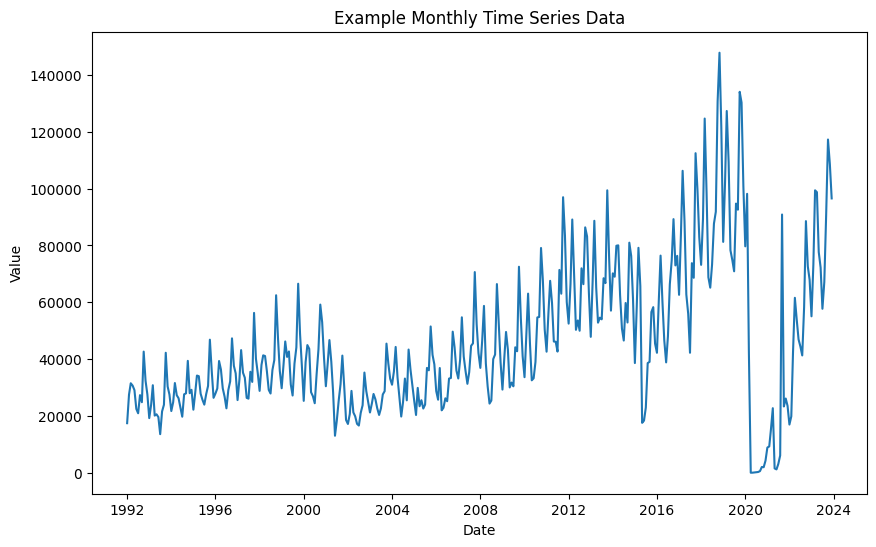

In [139]:
# Plot example time series data
plt.figure(figsize=(10, 6))
plt.plot(data['Arrivals'])
plt.title('Example Monthly Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('/content/Monthly_arrival_data.csv')
# data={'Date': df['Date'],
#       'Arrival':df['Arrivals']}
# # Convert the 'Date' column to datetime
# # Convert the 'Date' column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y').dt.to_period('M')
df.set_index('Date', inplace=True)
# Display the DataFrame
df= df.asfreq('M')
print(df.tail())


In [93]:
df.index

PeriodIndex(['1992-01', '1992-02', '1992-03', '1992-04', '1992-05', '1992-06',
             '1992-07', '1992-08', '1992-09', '1992-10',
             ...
             '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08',
             '2023-09', '2023-10', '2023-11', '2023-12'],
            dtype='period[M]', name='Date', length=384)

In [ ]:
df.index

In [ ]:
# Define COVID-19 period
covid_start_date = pd.to_datetime('2020-03')
covid_end_date = pd.to_datetime('2021-06')
covid_effect = ((df.index >= covid_start_date) & (df.index <= covid_end_date)).astype(int)
# Incorporate COVID-19 effect into the time series data
data = df + covid_effect

In [67]:
df

,Arrivals
Date,
1992-01-31,NaN
1992-02-29,NaN
1992-03-31,NaN
1992-04-30,NaN
1992-05-31,NaN
...,...
2023-07-31,NaN
2023-08-31,NaN
2023-09-30,NaN


In [57]:
# Generate example monthly time series data
start_date = pd.to_datetime('2000-01')
end_date = pd.to_datetime('2021-12')
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # MS: month start frequency
n_months = len(date_range)
trend = 0.1 * np.arange(n_months)
seasonality = 10 * np.sin(np.linspace(0, 4*np.pi, num=n_months))
noise = np.random.normal(loc=0, scale=1, size=n_months)
ts_data = pd.Series(trend + seasonality + noise, index=date_range)

# Define COVID-19 period
covid_start_date = pd.to_datetime('2020-03')
covid_end_date = pd.to_datetime('2021-06')
covid_effect = ((ts_data.index >= covid_start_date) & (ts_data.index <= covid_end_date)).astype(int)


In [ ]:
# Fit SARIMA model with COVID effect
model = SARIMAX(df, exog=covid_effect, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Print model summary
print(results.summary())

# Plot observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df, label='Observed')
plt.plot(results.fittedvalues, color='red', label='Predicted')
plt.fill_between(df.index, df.min(), df.max(), where=covid_effect, color='gray', alpha=0.3, label='COVID-19 Period')
plt.title('Observed vs. Predicted with COVID-19 Effect')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Function to generate time series data in "2000-01" format
def generate_time_series(start_year, end_year):
    date_range = pd.date_range(start=f'{start_year}-01', end=f'{end_year}-12', freq='MS')
    ts_data = pd.Series(np.random.randn(len(date_range)), index=date_range)
    return ts_data

# Generate time series data
start_year = 2000
end_year = 2021
ts_data = generate_time_series(start_year, end_year)

# Define COVID-19 period
covid_start_year = 2020
covid_end_year = 2021
covid_effect = ((ts_data.index.year >= covid_start_year) & (ts_data.index.year <= covid_end_year)).astype(int)

# Incorporate COVID-19 effect into the time series data
ts_data_with_covid = ts_data + covid_effect

# Plot time series data
plt.figure(figsize=(10, 6))
plt.plot(ts_data_with_covid)
plt.title('Time Series Data with COVID-19 Effect')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Function to test stationarity
def test_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Test stationarity with COVID effect
print('Testing Stationarity of Time Series Data with COVID-19 Effect:')
test_stationarity(ts_data_with_covid)

# Plot ACF and PACF with COVID effect
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_data_with_covid, ax=ax[0], lags=20)
plot_pacf(ts_data_with_covid, ax=ax[1], lags=20)
plt.show()

# Determine ARIMA and SARIMA orders
order = (1, 1, 1)  # Example ARIMA order
seasonal_order = (1, 1, 1, 12)  # Example SARIMA seasonal order

# Execute SARIMA model
sarima_model = SARIMAX(ts_data_with_covid, order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Execute Holt-Winters Exponential Smoothing model
holtwinter_model = ExponentialSmoothing(ts_data_with_covid, seasonal='add', seasonal_periods=12)
holtwinter_results = holtwinter_model.fit()

# Forecast for the next five years with SARIMA
forecast_sarima = sarima_results.get_forecast(steps=60)
sarima_predictions = forecast_sarima.predicted_mean
sarima_conf_int = forecast_sarima.conf_int(alpha=0.05)

# Forecast for the next five years with Holt-Winters
forecast_holtwinter = holtwinter_results.forecast(steps=60)

# Plot SARIMA forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(ts_data_with_covid, label='Actual')
plt.plot(sarima_predictions.index, sarima_predictions, color='red', label='SARIMA Forecast')
plt.fill_between(sarima_predictions.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot Holt-Winters forecast
plt.figure(figsize=(10, 6))
plt.plot(ts_data_with_covid, label='Actual')
plt.plot(forecast_holtwinter.index, forecast_holtwinter, color='green', label='Holt-Winters Forecast')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [29]:
ts_data_with_covid

2000-01-01    0.014273
2000-02-01   -0.953939
2000-03-01   -0.407036
2000-04-01    0.686318
2000-05-01    0.105894
                ...   
2021-08-01    1.813205
2021-09-01    0.721037
2021-10-01    0.720240
2021-11-01    1.790372
2021-12-01    1.340051
Freq: MS, Length: 264, dtype: float64

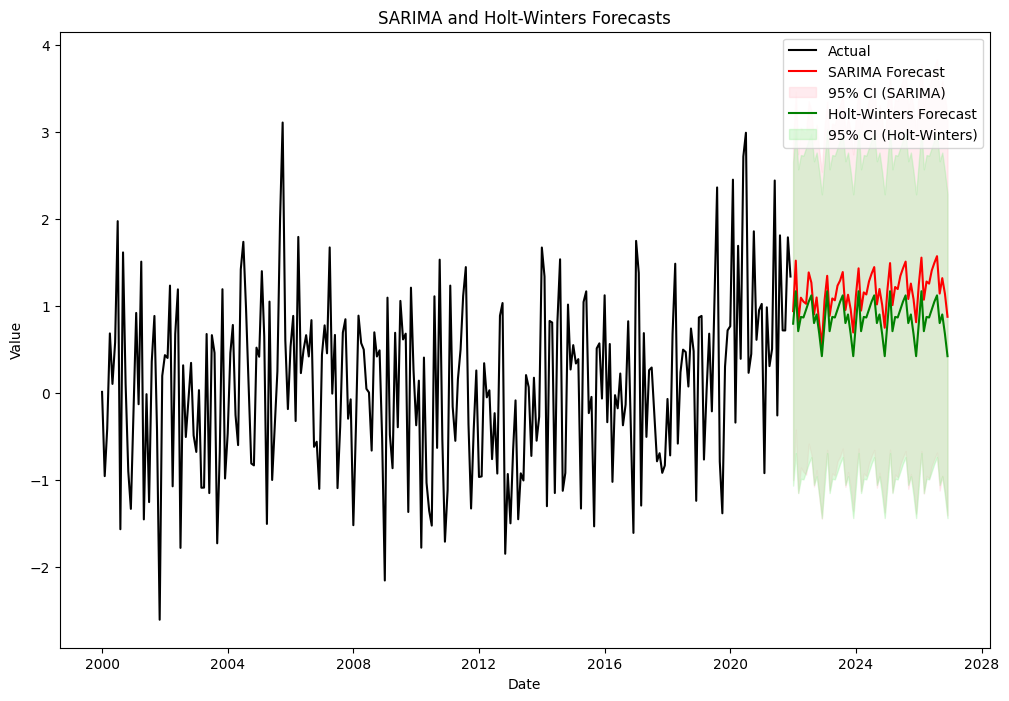

In [27]:
# Plot both SARIMA and Holt-Winters forecasts in the same figure
plt.figure(figsize=(12, 8))
plt.plot(ts_data_with_covid, label='Actual', color='black')

# SARIMA forecast with confidence intervals
plt.plot(sarima_predictions.index, sarima_predictions, color='red', label='SARIMA Forecast')
plt.fill_between(sarima_predictions.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% CI (SARIMA)')

# Holt-Winters forecast with manually calculated confidence intervals
holtwinter_forecast_upper = forecast_holtwinter + 1.96 * holtwinter_results.resid.std()
holtwinter_forecast_lower = forecast_holtwinter - 1.96 * holtwinter_results.resid.std()
plt.plot(forecast_holtwinter.index, forecast_holtwinter, color='green', label='Holt-Winters Forecast')
plt.fill_between(forecast_holtwinter.index, holtwinter_forecast_lower, holtwinter_forecast_upper, color='lightgreen', alpha=0.3, label='95% CI (Holt-Winters)')

plt.title('SARIMA and Holt-Winters Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


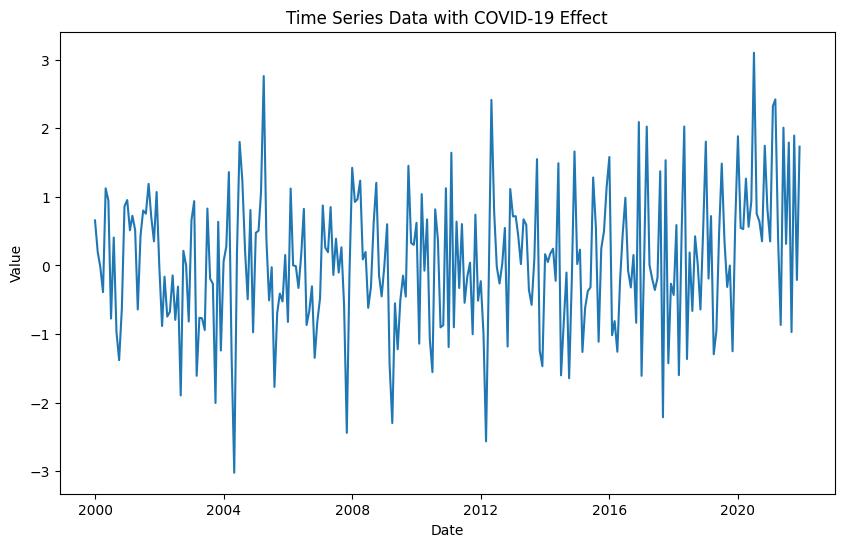

Testing Stationarity of Time Series Data with COVID-19 Effect:
ADF Statistic: -14.882231001601854
p-value: 1.602967655066874e-27
Critical Values:
	1%: -3.4554613060274972
	5%: -2.8725931472675046
	10%: -2.5726600403359887


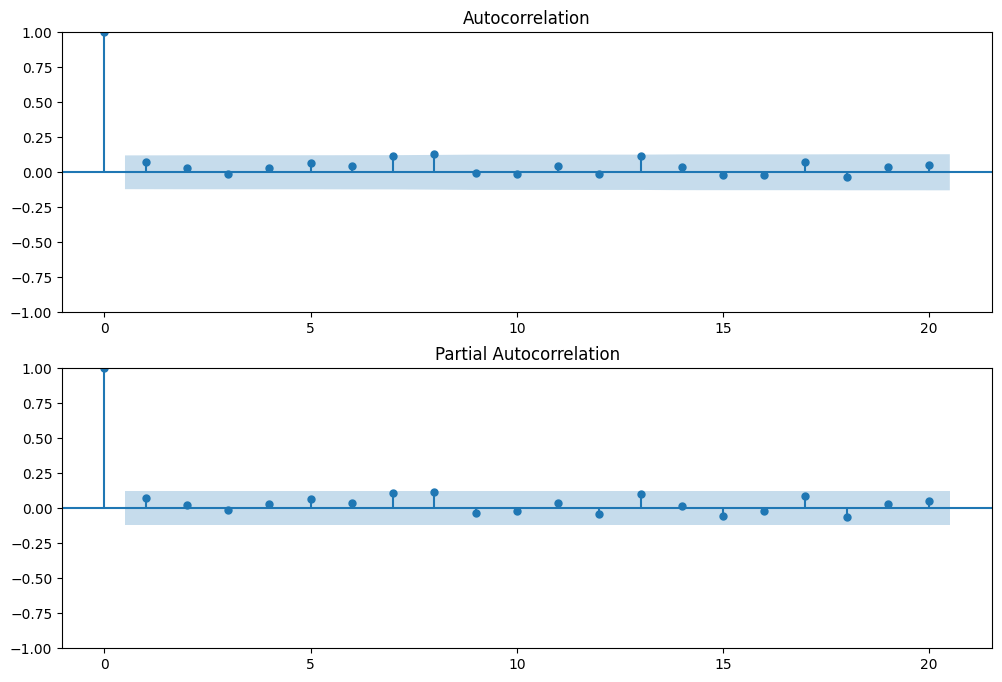

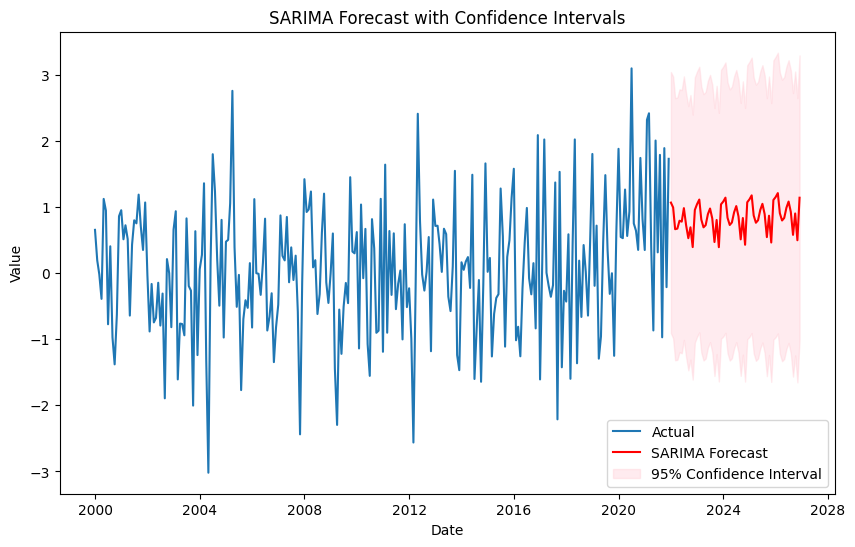

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Function to generate time series data in "2000-01" format
def generate_time_series(start_year, end_year):
    date_range = pd.date_range(start=f'{start_year}-01', end=f'{end_year}-12', freq='MS')
    ts_data = pd.Series(np.random.randn(len(date_range)), index=date_range)
    return ts_data

# Generate time series data
start_year = 2000
end_year = 2021
ts_data = generate_time_series(start_year, end_year)

# Define COVID-19 period
covid_start_year = 2020
covid_end_year = 2021
covid_effect = ((ts_data.index.year >= covid_start_year) & (ts_data.index.year <= covid_end_year)).astype(int)

# Incorporate COVID-19 effect into the time series data
ts_data_with_covid = ts_data + covid_effect

# Plot time series data
plt.figure(figsize=(10, 6))
plt.plot(ts_data_with_covid)
plt.title('Time Series Data with COVID-19 Effect')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Function to test stationarity
def test_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Test stationarity with COVID effect
print('Testing Stationarity of Time Series Data with COVID-19 Effect:')
test_stationarity(ts_data_with_covid)

# Plot ACF and PACF with COVID effect
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_data_with_covid, ax=ax[0], lags=20)
plot_pacf(ts_data_with_covid, ax=ax[1], lags=20)
plt.show()

# Determine ARIMA and SARIMA orders
order = (1, 1, 1)  # Example ARIMA order
seasonal_order = (1, 1, 1, 12)  # Example SARIMA seasonal order

# Execute SARIMA model
sarima_model = SARIMAX(ts_data_with_covid, order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Forecast for the next five years with SARIMA
forecast_sarima = sarima_results.get_forecast(steps=60)
sarima_predictions = forecast_sarima.predicted_mean
sarima_conf_int = forecast_sarima.conf_int(alpha=0.05)

# Plot SARIMA forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(ts_data_with_covid, label='Actual')
plt.plot(sarima_predictions.index, sarima_predictions, color='red', label='SARIMA Forecast')
plt.fill_between(sarima_predictions.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Generate sample time series data with monthly granularity
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-01')
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # MS: month start frequency
data = np.random.normal(loc=0, scale=1, size=len(date_range))
ts_data = pd.Series(data, index=date_range)

# Define COVID-19 period
covid_start_date = pd.to_datetime('2020-03-01')
covid_end_date = pd.to_datetime('2021-06-01')

# Create COVID-19 variable
covid_effect = ((ts_data.index >= covid_start_date) & (ts_data.index <= covid_end_date)).astype(int)

# Define SARIMA model parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit SARIMA model with COVID effect
model = SARIMAX(ts_data, exog=covid_effect, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Print model summary
print(results.summary())

# Plot observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Observed')
plt.plot(results.fittedvalues, color='red', label='Predicted')
plt.fill_between(ts_data.index, ts_data.min(), ts_data.max(), where=covid_effect, color='gray', alpha=0.3, label='COVID-19 Period')
plt.title('Observed vs. Predicted with COVID-19 Effect')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


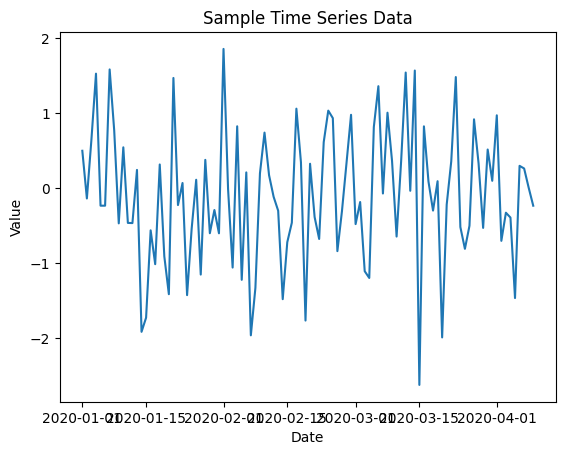

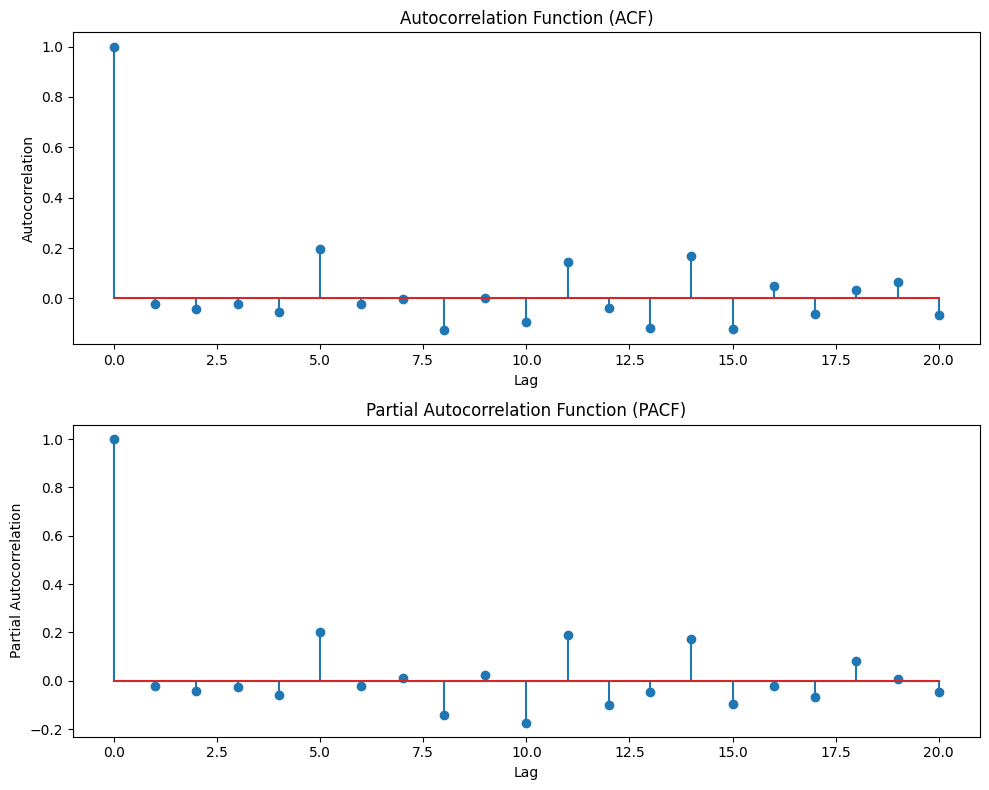

Non-seasonal order (p, d, q): (5, 1, 0)


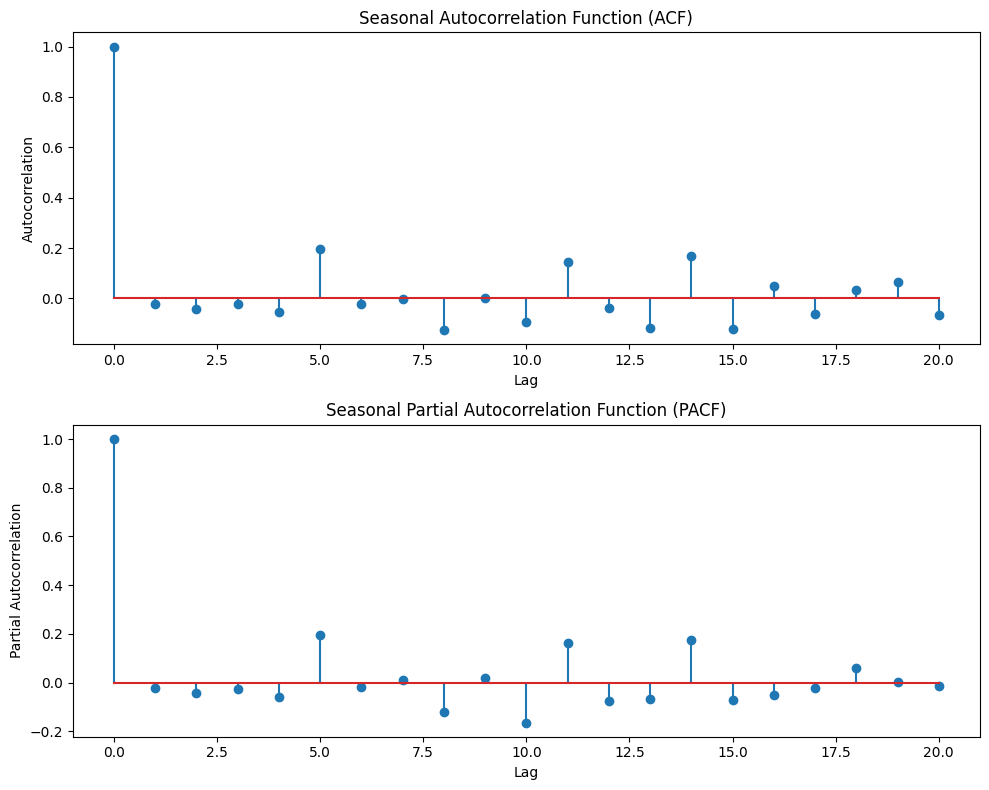

Seasonal order (P, D, Q, s): (0, 0, 0, 12)


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf, pacf

# Generate some sample time series data
np.random.seed(42)
date_range = pd.date_range(start='1/1/2020', periods=100, freq='D')
data = np.random.normal(loc=0, scale=1, size=100)
ts_data = pd.Series(data, index=date_range)

# Visualize the time series data
plt.plot(ts_data)
plt.title('Sample Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot the autocorrelation and partial autocorrelation functions
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

acf_values, confint = acf(ts_data, nlags=20, alpha=0.05)
pacf_values, confint = pacf(ts_data, nlags=20, alpha=0.05)

ax[0].stem(acf_values)
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

ax[1].stem(pacf_values)
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Determine order based on threshold
threshold = 0.2  # Example threshold value, adjust as needed
order_acf = np.where(acf_values > threshold)[0].max()
order_pacf = np.where(pacf_values > threshold)[0].max()

# Display order values
print(f'Non-seasonal order (p, d, q): ({order_pacf}, 1, {order_acf})')

# Plot the seasonal autocorrelation and partial autocorrelation functions
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

s_acf_values, confint = acf(ts_data, nlags=20, alpha=0.05, fft=True)
s_pacf_values, confint = pacf(ts_data, nlags=20, alpha=0.05, method='ols')

ax[0].stem(s_acf_values)
ax[0].set_title('Seasonal Autocorrelation Function (ACF)')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

ax[1].stem(s_pacf_values)
ax[1].set_title('Seasonal Partial Autocorrelation Function (PACF)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Determine seasonal order based on threshold
s_threshold = 0.4  # Example threshold value, adjust as needed
s_order_acf = np.where(s_acf_values > s_threshold)[0].max()
s_order_pacf = np.where(s_pacf_values > s_threshold)[0].max()

# Display seasonal order values
print(f'Seasonal order (P, D, Q, s): ({s_order_pacf}, 0, {s_order_acf}, 12)')


array([0])

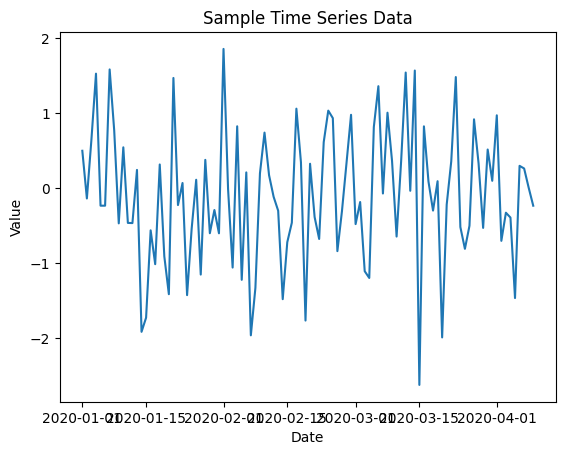

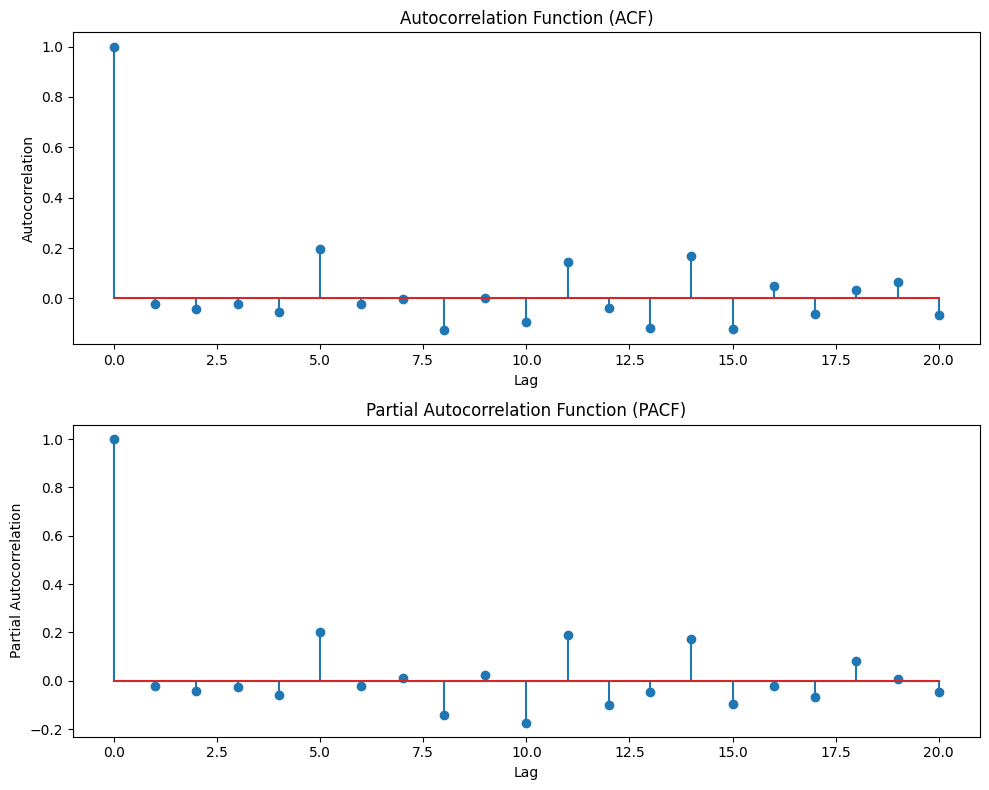

Non-seasonal order (p, d, q): (5, 1, 0)


In [9]:
# non seanonal model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf, pacf

# Generate some sample time series data
np.random.seed(42)
date_range = pd.date_range(start='1/1/2020', periods=100, freq='D')
data = np.random.normal(loc=0, scale=1, size=100)
ts_data = pd.Series(data, index=date_range)

# Visualize the time series data
plt.plot(ts_data)
plt.title('Sample Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot the autocorrelation and partial autocorrelation functions
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

acf_values, confint = acf(ts_data, nlags=20, alpha=0.05)
pacf_values, confint = pacf(ts_data, nlags=20, alpha=0.05)

ax[0].stem(acf_values)
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

ax[1].stem(pacf_values)
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Determine order based on threshold
threshold = 0.2  # Example threshold value, adjust as needed
order_acf = np.where(acf_values > threshold)[0].max()
order_pacf = np.where(pacf_values > threshold)[0].max()

# Display order values
print(f'Non-seasonal order (p, d, q): ({order_pacf}, 1, {order_acf})')


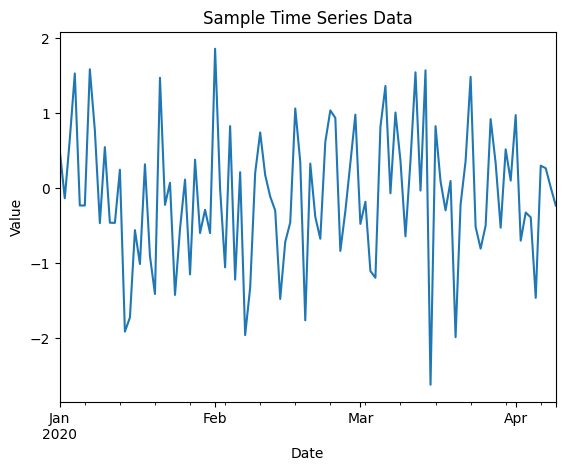

ADF Statistic: -10.084425913669714
p-value: 1.1655044784188669e-17
Critical Values: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
The time series is stationary.
ADF Statistic: -5.194567863079884
p-value: 9.019393985741834e-06
Critical Values: {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}
The time series is stationary.


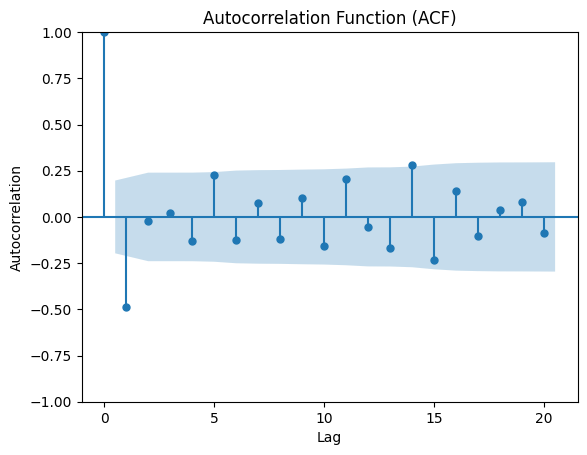

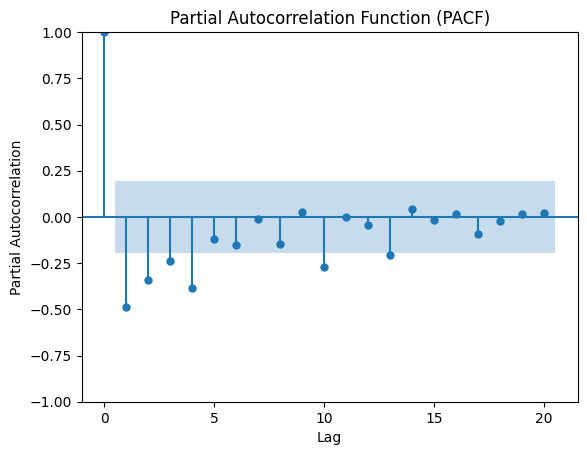

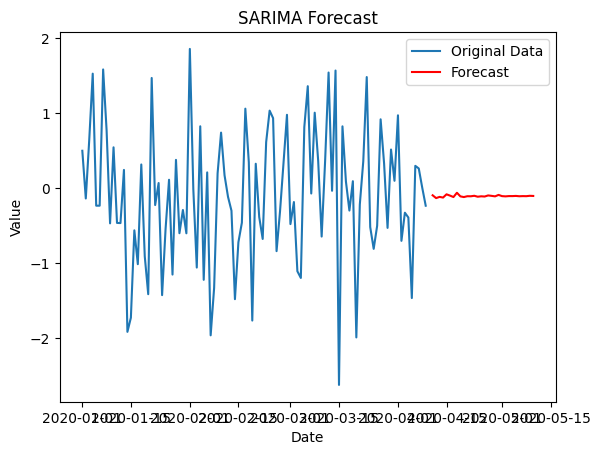

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Generate some sample time series data
np.random.seed(42)
date_range = pd.date_range(start='1/1/2020', periods=100, freq='D')
data = np.random.normal(loc=0, scale=1, size=100)
ts_data = pd.Series(data, index=date_range)

# Visualize the time series data
ts_data.plot()
plt.title('Sample Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Function to check stationarity
def check_stationarity(timeseries):
    # Perform ADF test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

# Check stationarity
check_stationarity(ts_data)

# Process non-stationary time series
# Example: Take first difference
ts_data_diff = ts_data.diff().dropna()

# Check stationarity of differenced series
check_stationarity(ts_data_diff)

# Plot autocorrelation and partial autocorrelation functions
plot_acf(ts_data_diff, lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plot_pacf(ts_data_diff, lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Fit SARIMA model to differenced series
order = (1, 0, 1)  # ARIMA order
seasonal_order = (1, 0, 1, 12)  # Seasonal order
model = SARIMAX(ts_data_diff, order=order, seasonal_order=seasonal_order)
sarima_model = model.fit(disp=False)

# Forecast
forecast_steps = 30
forecast_diff = sarima_model.forecast(steps=forecast_steps)

# Convert differenced forecast to original scale
forecast = ts_data.iloc[-1] + np.cumsum(forecast_diff)

# Plot original data and forecast
plt.plot(ts_data, label='Original Data')
plt.plot(pd.date_range(start='4/11/2020', periods=forecast_steps, freq='D'), forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# two time series data SARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Generate some sample time series data
np.random.seed(42)
date_range = pd.date_range(start='1/1/2020', periods=100, freq='D')
data1 = np.random.normal(loc=0, scale=1, size=100)
data2 = np.random.normal(loc=0, scale=1, size=100)
ts_data1 = pd.Series(data1, index=date_range)
ts_data2 = pd.Series(data2, index=date_range)

# Visualize the time series data
plt.plot(ts_data1, label='Time Series 1')
plt.plot(ts_data2, label='Time Series 2')
plt.title('Sample Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Function to check stationarity
def check_stationarity(timeseries):
    # Perform ADF test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

# Check stationarity for both time series
print("Time Series 1:")
check_stationarity(ts_data1)
print("\nTime Series 2:")
check_stationarity(ts_data2)

# Fit SARIMA model to one of the time series (example: ts_data1)
order = (1, 0, 1)  # ARIMA order
seasonal_order = (1, 0, 1, 12)  # Seasonal order
model = SARIMAX(ts_data1, order=order, seasonal_order=seasonal_order)
sarima_model = model.fit(disp=False)

# Forecast
forecast_steps = 30
forecast = sarima_model.forecast(steps=forecast_steps)

# Plot original data and forecast
plt.plot(ts_data1, label='Original Data')
plt.plot(pd.date_range(start='4/11/2020', periods=forecast_steps, freq='D'), forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 2: Load and Prepare Data
# Assuming your data is stored in a DataFrame called 'df' with a column named 'value'
# Example: df = pd.read_csv('your_data.csv')

# Step 3: Visualize Data
plt.figure(figsize=(10, 6))
plt.plot(df['value'])
plt.title('Monthly Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Step 4: Stationarize Data (if necessary)
# Example: df['stationary'] = df['value'].diff().dropna()

# Step 5: Identify Parameters
# Example: plot_acf(df['stationary'])
#          plot_pacf(df['stationary'])

# Step 6: Fit SARIMA Model
# Example: model = SARIMAX(df['value'], order=(p, d, q), seasonal_order=(P, D, Q, s))
#          fitted_model = model.fit()

# Step 7: Evaluate Model
# Example: print(fitted_model.summary())

# Step 8: Forecast
# Example: forecast = fitted_model.forecast(steps=n)
